In [1]:
df_sinai = pd.read_csv("../mount-sinai-vaccine/sinai-vaccine-peptides-v1-04-15-2020.csv")

In [2]:
df_sinai

,Name,Sequence,Start,End,Length,Domain,Glycosylation,Polymorphism,PEPperPRINT\nEpitope,PEPperPRINT \nIgG,PEPperPRINT\n IgA,Wang 2020,Poh 2020 Epitope,Notes,MHC-II epitopes
0,S453-15mer,YRLFRKSNLKPFERD,453,467,15,RBM,NaN,NaN,453-YRLFRKSNLKPFERD-467,1 strong,1 weak,Contains:\n456-FRKSN-460,NaN,Only in 2nd PEPperPRINT spreadsheet\n(single p...,NaN
1,S459-15mer,SNLKPFERDISTEIY,459,473,15,RBM,NaN,NaN,459-SNLKPFERDISTEIY-473,3,2,2aa overlap with:\n456-FRKSN-460,NaN,original PEPperPRINT spreadsheet hit,NaN
2,S505-18mer,YQPYRVVVLSFELLHAPA,505,522,18,RBD,NaN,NaN,505-YQPYRVVVLSFELLH-519,2,2,NaN,NaN,have MHC-II epitopes on the right,Multiple NetMHCIIpan 3.2 binding predictions\n...
3,S569-19mer,IADTTDAVRDPQTLEILDI,569,587,19,28aa downsteam\n of RBD,NaN,NaN,"569-IADTTDAVRDPQTLE-583, \n571-DTTDAVRDPQTLEIL...",3,1,NaN,NaN,made of 3 overlapping PEPperPRINT epitopes,NaN
4,S553-Neutralizing-S14P5-18mer,TESNKKFLPFQQFGRDIA,553,570,18,12aa downstream\nof RBD,NaN,NaN,NaN,NaN,NaN,NaN,Exact match:\n553-TESNKKFLPFQQFGRDIA-570,NaN,NaN
5,S806-Neutralizing-S21P2-21mer,LPDPSKPSKRSFIEDLLFNKV,806,826,21,C terminus of\nfusion peptide \n(FP),NaN,NaN,Contains:\n807-PDPSKPSKRSFIEDL-821,2,0,Contains:\n806-LPDPSKPSKRSFIED-820,Contains:\n809-PSKPSKRSFIEDLLFNKV-826,Extended Poh 2020 neutralizing anitibody epito...,NaN


In [3]:
df_solvent = pd.read_csv("Woods-Glycans-MD-Site-Specific-Accessibility.csv"); 
df_solvent

,Residue Proper Numbering,SiteSpecific Accessiblity,Nude Accessibility,Difference
0,27,0.94,0.99,0.05
1,28,0.99,1.00,0.01
2,29,0.15,0.26,0.11
3,30,0.36,0.76,0.40
4,31,0.00,0.00,0.00
...,...,...,...,...
1115,1142,0.78,0.89,0.11
1116,1143,0.66,0.70,0.04
1117,1144,0.78,0.79,0.01
1118,1145,0.85,0.86,0.00


In [8]:
from collections import OrderedDict, defaultdict

resiNums = df_solvent["Residue Proper Numbering"]
accessibilities = df_solvent["SiteSpecific Accessiblity"]

all_possible_positions = set(range(1, resiNums.max()))
positions_in_model = set(resiNums)
missing_positions = all_possible_positions.difference(positions_in_model)



pos_to_rsa = {resiNum: rsa for resiNum, rsa in zip(resiNums, accessibilities)}

new_columns = OrderedDict([
    ("resiNum", []),
    ("relative_solvent_accessibility", []),
    ("missing", []),
    ("vaccine_peptide_names", []),
    ("in_vaccine_peptide", []),
    ("residue_description", []),
])

pos_to_vaccine_peptide_names = defaultdict(list)

for vaccine_peptide_name, start, end in zip(df_sinai.Name, df_sinai.Start, df_sinai.End):
    for pos in range(start, end + 1):
        pos_to_vaccine_peptide_names[pos].append(vaccine_peptide_name)
    
for pos in sorted(all_possible_positions):
 
    if pos in pos_to_rsa:

   
        rsa = pos_to_rsa[pos]
        missing = False
    else:
        rsa = 0
        missing = True
    vaccine_peptide_names = pos_to_vaccine_peptide_names[pos]
    in_vaccine_peptide = len(vaccine_peptide_names) > 0
    if in_vaccine_peptide and missing:
          description = "vaccine + missing"
    elif in_vaccine_peptide:
        description = "vaccine"
    elif missing:
        description = "missing"
    else:
        description = "not vaccine"
    
    new_columns["resiNum"].append(pos)
    new_columns["relative_solvent_accessibility"].append(rsa)
    new_columns["missing"].append(missing)
    new_columns["vaccine_peptide_names"].append(tuple(sorted(vaccine_peptide_names)))
    new_columns["in_vaccine_peptide"].append(in_vaccine_peptide)
    new_columns["residue_description"].append(description)

df = pd.DataFrame(new_columns)
df["num_vaccine_peptides"] = df["vaccine_peptide_names"].map(len)

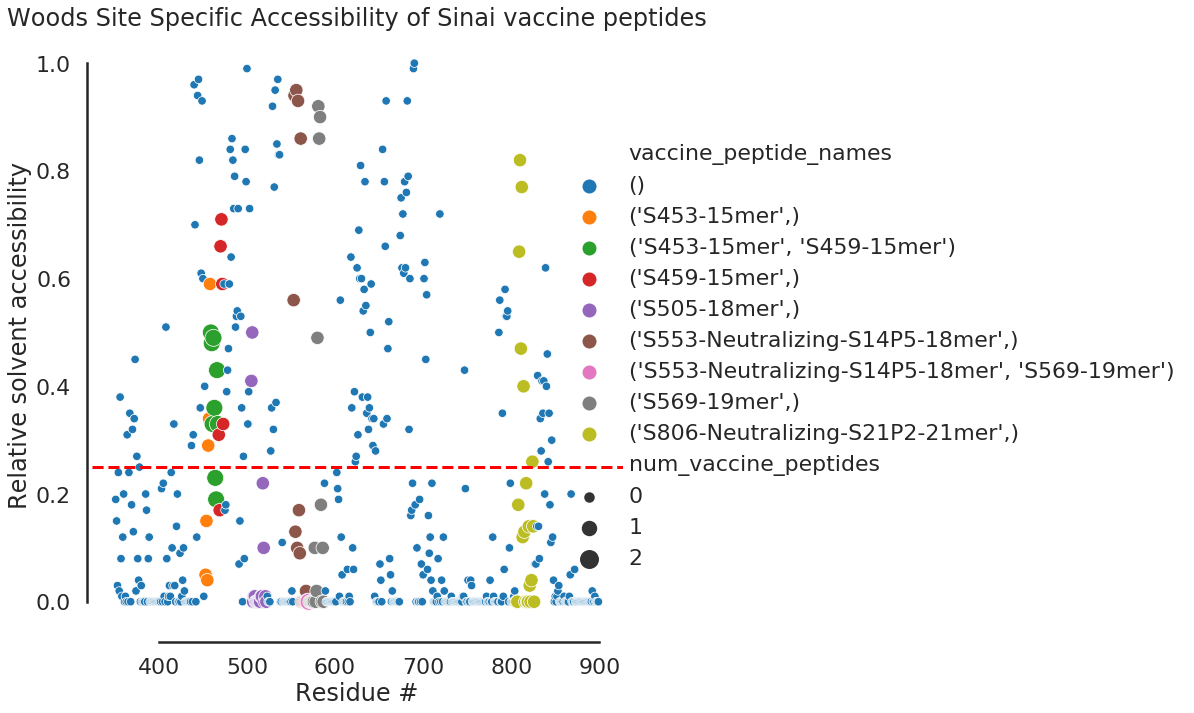

In [18]:

%matplotlib inline
import seaborn
import matplotlib.pyplot as plt


with seaborn.axes_style("white"), seaborn.plotting_context("poster"):
    g = seaborn.relplot(
        data=df[(df.resiNum > 350) & (df.resiNum < 900)], 
        x="resiNum", 
        y="relative_solvent_accessibility",
        height=10,
        hue="vaccine_peptide_names",
        size="num_vaccine_peptides",)
    seaborn.despine(offset=5, trim=True);
    plt.xlabel("Residue #")
    plt.ylabel("Relative solvent accessibility")
    plt.title("Woods Site Specific Accessibility of Sinai vaccine peptides")
    ax = g.axes[0][0]
    ax.axhline(0.25, ls='--', color="red")
    g.savefig("woods-md-site-specific-accessibility-sinai-vaccine-peptides.png")


In [66]:
len(df_solvent[(df_solvent.resiNum >300) & (df_solvent.resiNum < 900)])

511

In [17]:
df.vaccine_peptide_names.value_counts()

()                                             1050
(S806-Neutralizing-S21P2-21mer,)                 21
(S505-18mer,)                                    18
(S569-19mer,)                                    17
(S553-Neutralizing-S14P5-18mer,)                 16
(S453-15mer, S459-15mer)                          9
(S453-15mer,)                                     6
(S459-15mer,)                                     6
(S553-Neutralizing-S14P5-18mer, S569-19mer)       2
Name: vaccine_peptide_names, dtype: int64